# Machine Learning Engineer Nanodegree

## Imports and setup

In [1]:
# Print stuff inline
%matplotlib inline

# Imports
import re
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
# from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import AdaBoostClassifier
from sklearn import cross_validation
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from string import digits
from bs4 import BeautifulSoup
import warnings
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn import grid_search

from sklearn.svm import l1_min_c

import keras
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer

from wordcloud import WordCloud, STOPWORDS


# Ignore depreation warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')

Using TensorFlow backend.


In [161]:
# http://stackoverflow.com/questions/33181846/programmatically-convert-pandas-dataframe-to-markdown-table
def pandas_df_to_markdown_table(df):
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    return "|" + df_formatted.to_csv(line_terminator="|\n|", sep="|", index=False)[:-1]

## Read in data

In [2]:
# Load he data and drop columns we don't care about.
try:
    data = pd.read_csv("Amazon_Unlocked_Mobile.csv")
    data.drop(['Product Name', 'Brand Name','Price','Review Votes'], axis = 1, inplace = True)
    print "{} Amazon mobile phone reviews with {} features each.".format(*data.shape)
except:
    print "You need to download the dataset from https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones"

413840 Amazon mobile phone reviews with 2 features each.


## Clean Data

In [4]:
def clean_text(string): 
    warnings.filterwarnings('ignore') # I don't need a lecture, BeautifulSoup
    review_text = BeautifulSoup(string, "lxml").get_text()
    warnings.resetwarnings() # Turn warnings back on
    string = re.sub("[^a-zA-Z]"," ", string)
    string = string.lower()
    return string

In [5]:
data = data[data['Reviews'].isnull()==False]
ratings = data['Rating']
reviews = map(clean_text, data['Reviews'])

## Explore Data

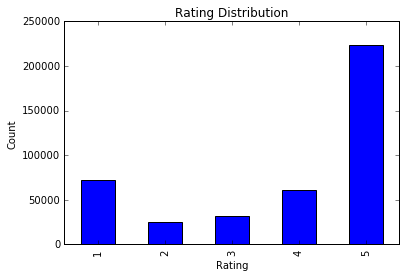

In [6]:
rating_distribution_plt = data.groupby(['Rating']).count().plot(kind='bar', legend=None, title="Rating Distribution")
rating_distribution_plt.set_xlabel("Rating")
rating_distribution_plt.set_ylabel("Count")

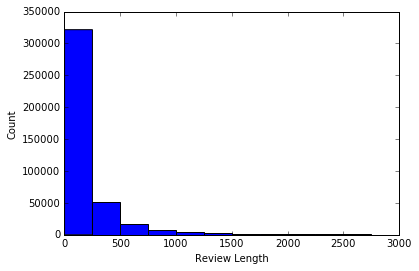

In [7]:
review_length_distribution_plt = pd.DataFrame(data["Reviews"].str.len())
review_length_distribution_plt = review_length_distribution_plt[review_length_distribution_plt.Reviews < 3000]
review_length_distribution_plt.groupby(["Reviews"])
review_length_distribution_plt = review_length_distribution_plt.plot(kind='hist', legend=None, bins=12)
review_length_distribution_plt.set_xlabel("Review Length")
review_length_distribution_plt.set_ylabel("Count")

## Feature Extraction

In [8]:
vectorizer = TfidfVectorizer(min_df=2,               # Ignore phrases that are in fewer than 2 reviews
                             max_df=0.95,            # Ignore phrases that are in 95% of reviews
                             sublinear_tf = True,    # 
                             ngram_range = (1,4),    # Take phrases between 1 and 4 words
                             stop_words = 'english', # Remove common English words
                             # max_features = 300 # The max features amount of features. Set this to 
                                                     # something small when getting most relevant phrases to 
                                                     # prevent crases (We have to do some array conversions which 
                                                     # take a lot of memory)
                            )

review_features = vectorizer.fit_transform(reviews)

### Get most relevant  phrases

In [9]:
# reviews_new = SelectKBest(chi2, k=200).fit_transform(review_features, ratings)

In [10]:
def get_most_relevant_phrases():
    feature_array = np.array(vectorizer.get_feature_names())
    tfidf_sorting = np.argsort(review_features.toarray()).flatten()[::-1]
    top_n = feature_array[tfidf_sorting][:8]
    return top_n
    

In [11]:
# It's important to not run this unless you set max_features in TfidfVectorizer to something small. 
# The array conversions can take a lot of memory.
# print get_most_relevant_phrases()

## Train/Test Split

In [12]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
                                            review_features,  # The features we created from the reviews
                                            ratings,          # The ratings we are trying to predict
                                            stratify=ratings, # We have an imbalance of 5-star reviews, so let's stratify
                                            test_size = 0.3   # We need to save 30% of the data for testing
                                            )
print X_train.shape

(289645, 3553789)


In [182]:
example_review_set = pd.DataFrame(y_test[103:111].index).join(data).sort_values(by=0)
pd.set_option("display.max_colwidth", 1000)
print pandas_df_to_markdown_table(example_review_set[['Rating','Reviews']])
pd.set_option("display.max_colwidth", 50)

|Rating|Reviews|
|---|---|
|2|The charging port was loose. I got that soldered in. Then needed a new battery as well. $100 later (not including cost of purchase) I have a usable phone. The phone should not have been sold in the state it was in.|
|5|I feel so LUCKY to have found this used (phone to us & not used hard at all), phone on line from someone who upgraded and sold this one. My Son liked his old one that finally fell apart after 2.5+ years and didn't want an upgrade!! Thank you Seller, we really appreciate it & your honesty re: said used phone.I recommend this seller very highly & would but from them again!!|
|4|nice phone, nice up grade from my pantach revue. Very clean set up and easy set up. never had an android phone but they are fantastic to say the least. perfect size for surfing and social media. great phone samsung|
|4|It works good but it goes slow sometimes but its a very good phone I love it|
|5|Very pleased|
|2|Phone looks good but wouldn't stay charged, had to buy 

### Benchmark model

In [13]:
clf0 = linear_model.LogisticRegression(solver='sag').fit(X_train, y_train)

### Other models 

In [ ]:
cs = l1_min_c(X_train, y_train, loss='log') * np.logspace(0, 3)

In [5]:
list(np.power(10.0, np.arange(-3, 3)))

[0.001, 0.01, 0.10000000000000001, 1.0, 10.0, 100.0]

In [18]:
clf1 = linear_model.LogisticRegressionCV(
    Cs=list(np.power(10.0, np.arange(-3, 3)))
    ,penalty='l2'
    ,scoring='f1'
    # ,cv=fold
    #,random_state=777
    #,max_iter=10000
    #,fit_intercept=True
    ,solver='sag'
    #,tol=10
    ,verbose = 1
)
clf1.fit(X_train, y_train)

# LR = linear_model.LogisticRegressionCV(penalty='l2', solver='sag')
# clf1 = grid_search.GridSearchCV(LR, parameters)
# clf1.fit(X_train, y_train)

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

/Users/garrisonjensen/anaconda/lib/python2.7/site-packages/sklearn/linear_model/sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/garrisonjensen/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 23.3min finished


KeyboardInterrupt: 

In [14]:
#parameters = { 'alpha': [0.1, 0.25, 0.5, 0.75, 1.0] }
#MDB = MultinomialNB()
#clf2 = grid_search.GridSearchCV(MDB, parameters)
clf2 = MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)
clf2.fit(X_train, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [15]:
# parameters = {'alpha':10.0**-np.arange(1,7),'penalty':[None, 'l2', 'l1', 'elasticnet']}
# parameters = [{'alpha' : 10.0**-np.arange(1,7),'l1_ratio':[.05, .15, .5, .7, .9, .95, .99, 1]}]

#parameters = [{'alpha': [0.000001, 0.00001, 0.0001, 0.001, 0.01], 'penalty': ['l1', 'l2', 'elasticnet']}]
#SGD = linear_model.SGDClassifier()
#clf3 = grid_search.GridSearchCV(SGD, parameters)
clf3 = linear_model. SGDClassifier(alpha=1e-06, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
clf3.fit(X_train, y_train)


SGDClassifier(alpha=1e-06, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [20]:
print clf2.best_estimator_
print clf3.best_estimator_

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)
SGDClassifier(alpha=1e-06, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


In [ ]:
# parameters = [{'learning_rate': [1.0]}]
# ABC = AdaBoostClassifier()
# clf3 = grid_search.GridSearchCV(ABC, parameters)
# clf3.fit(X_train, y_train)
aReview = 700
print reviews[aReview]
print ratings[aReview]
clf2.predict(review_features[aReview])

In [36]:
num_classes = 5
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Dense(32, activation='relu', input_dim=100))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

one_hot_labels = keras.utils.to_categorical(y_train, num_classes=5)

model.fit(X_train, y_train, epochs=10, batch_size=32)

IndexError: index 5 is out of bounds for axis 1 with size 5

## Compare Models

In [15]:
print( "LogisticRegression (T): " + repr(f1_score(y_test, searchCV.predict(X_test), average='weighted')) )


LogisticRegression (T): 0.78428120153008618


In [17]:
print("F1-Scores: ")

print( "LogisticRegression:     " + repr(f1_score(y_test, clf0.predict(X_test), average='weighted')) )
# print( "LogisticRegression (T): " + repr(f1_score(y_test, searchCV.predict(X_test), average='weighted')) )
print( "MultinomialNB:          " + repr(f1_score(y_test, clf2.predict(X_test), average='weighted')) )
print( "SGDClassifier:          " + repr(f1_score(y_test, clf3.predict(X_test), average='weighted')) )

print("\nAccuracy: ")
# print( "AdaBoostClassifier: " + f1_score(y_test, clf3.predict(X_test), average='weighted') )
# print( "LogisticRegression: " + repr(accuracy_score(y_test, searchCV.predict(X_test))) )
print( "MultinomialNB:      " + repr(accuracy_score(y_test, clf2.predict(X_test))) )
print( "SGDClassifier:      " + repr(accuracy_score(y_test, clf3.predict(X_test))) )

print("\nclassification reports: ")
print( "LogisticRegression: " )
print (classification_report(y_test, clf0.predict(X_test)))
print( "MultinomialNB: " ) 
print( classification_report(y_test, clf2.predict(X_test)))
print( "SGDClassifier: " ) 
print(classification_report(y_test, clf3.predict(X_test)))

F1-Scores: 
LogisticRegression:     0.78623788061843891
MultinomialNB:          0.84090093728177373
SGDClassifier:          0.86074179302348108

Accuracy: 
MultinomialNB:      0.85047489386383957
SGDClassifier:      0.86789169680906775

classification reports: 
LogisticRegression: 
             precision    recall  f1-score   support

          1       0.78      0.92      0.85     21701
          2       0.94      0.39      0.55      7417
          3       0.89      0.43      0.58      9529
          4       0.83      0.41      0.55     18412
          5       0.81      0.98      0.89     67074

avg / total       0.82      0.81      0.79    124133

MultinomialNB: 
             precision    recall  f1-score   support

          1       0.86      0.91      0.88     21701
          2       0.94      0.61      0.74      7417
          3       0.87      0.60      0.71      9529
          4       0.85      0.56      0.68     18412
          5       0.84      0.97      0.90     67074

avg / t

In [174]:
example_reviews = X_test[103:111]

predicted1 = np.hstack(map(clf0.predict, example_reviews))
predicted2 = np.hstack(map(clf2.predict, example_reviews))
predicted3 = np.hstack(map(clf3.predict, example_reviews))

actual = np.array(y_test[103:111])

example_review_set = pd.DataFrame(y_test[103:111].index).join(data).sort_values(by=0)
example_review_text = example_review_set.Reviews

def shorten_text(x):
    length = 50
    r = x[:length]
    if len(x) > length:
        r = r + "..."
    return r
    
a = pd.DataFrame( { 
              'actual': actual,
              'p1': predicted1,
              'p2': predicted2,
              'p3': predicted3,
              'text': map(shorten_text, example_review_text)
              }
            )
print pandas_df_to_markdown_table(a)

|actual|p1|p2|p3|text|
|---|---|---|---|---|
|1|1|1|1|The charging port was loose. I got that soldered i...|
|5|5|5|5|I feel so LUCKY to have found this used (phone to ...|
|1|1|5|1|nice phone, nice up grade from my pantach revue. V...|
|3|1|3|3|It works good but it goes slow sometimes but its a...|
|2|2|4|2|Very pleased|
|4|1|4|4|Phone looks good but wouldn't stay charged, had to...|
|2|1|2|2|Great phone to replace my lost phone. The only thi...|
|4|5|4|4|I already had a phone with problems... I know it s...|



In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure( figsize=(9,4), facecolor='white')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(ratings)))
    plt.xticks(tick_marks, set(ratings), rotation=45)
    plt.yticks(tick_marks, set(ratings))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def create_and_print_confusion_matrix(y_test, predicted, title):
    cm = confusion_matrix(y_test, predicted)
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cm, title) 
    plt.show()


In [ ]:
create_and_print_confusion_matrix(y_test, clf1.predict(X_test),"MultinomialNB")


In [ ]:
create_and_print_confusion_matrix(y_test, clf2.predict(X_test), "SGDClassifier")


In [ ]:
create_and_print_confusion_matrix(y_test, clf0.predict(X_test), "LogisticRegression")


# Wordcloud

In [ ]:
word_string = ' '.join(reviews) # reduce(lambda x,y: x + " " + y, reviews, " ")

In [ ]:
wordcloud = WordCloud(   font_path='/System/Library/Fonts/Helvetica.dfont', 
                         stopwords=STOPWORDS,
                          background_color='white',
                          width=1600,
                          height=800
                         ).generate(word_string)

plt.figure( figsize=(20,10), facecolor='white')
plt.imshow(wordcloud)
plt.axis('off')
plt.show()